In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from pathlib import Path
import requests
from io import BytesIO

import torch
from torch import nn
import torchvision.transforms as T
import torchinfo
from PIL import Image
import matplotlib.pyplot as plt

from dataset import make_val_aug
from alexnet import AlexNet as MyAlexNet

# Local Response Normalization
What does that layer do? (visually)

In [3]:
def download_image(link: str):
    return Image.open(BytesIO(requests.get(link).content)).convert("RGB")

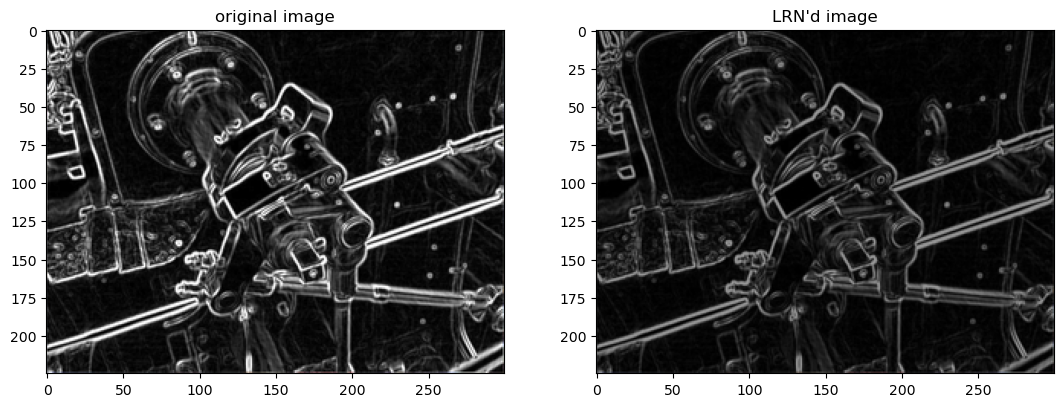

In [4]:
# download interesting images
orig_image = download_image("https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Valve_sobel_%283%29.PNG/300px-Valve_sobel_%283%29.PNG")

fig, axs = plt.subplots(1, 2, figsize=(13, 20))
axs[0].imshow(orig_image, cmap="Greys_r", vmin=0, vmax=255)
axs[0].set_title("original image")
mod_image = T.ToTensor()(orig_image)
mod_image = nn.LocalResponseNorm(size=3, alpha=1e-4, beta=0.75, k=2)(mod_image)
mod_image = T.ToPILImage()(mod_image)
axs[1].imshow(mod_image, cmap="Greys_r", vmin=0, vmax=255)
axs[1].set_title("LRN'd image")
plt.show()

# Try AlexNet
Note that the model is only trained for 72 epochs.

In [5]:
alexnet = MyAlexNet()
save_folder = Path("ckpt")
best_path = list(save_folder.glob("alexnet_best_*.pt"))[0]
alexnet.load_state_dict(torch.load(best_path))
alexnet.eval()

fake_inp = torch.randn(5, 3, 224, 224)
print(torchinfo.summary(alexnet, input_data=fake_inp, depth=1))  # should match figure in the paper
val_aug = make_val_aug()
imagenet_labels = eval(requests.get("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt").text)

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [5, 1000]                 --
├─Sequential: 1-1                        [5, 96, 55, 55]           34,944
├─Sequential: 1-2                        [5, 256, 27, 27]          614,656
├─Sequential: 1-3                        [5, 384, 13, 13]          885,120
├─Sequential: 1-4                        [5, 384, 13, 13]          1,327,488
├─Sequential: 1-5                        [5, 256, 13, 13]          884,992
├─Sequential: 1-6                        [5, 9216]                 --
├─Sequential: 1-7                        [5, 4096]                 37,752,832
├─Sequential: 1-8                        [5, 4096]                 16,781,312
├─Linear: 1-9                            [5, 1000]                 4,097,000
Total params: 62,378,344
Trainable params: 62,378,344
Non-trainable params: 0
Total mult-adds (G): 5.68
Input size (MB): 3.01
Forward/backward pass size (MB): 26.37
Params size

In [6]:
def predict_topk(model, id2name, val_aug, k, url):
    # download_image
    pil_image = download_image(url)
    plt.figure(figsize=(6, 3))
    plt.imshow(pil_image)
    plt.axis("off")
    plt.show()
    # predict
    image_tensor = val_aug(pil_image).unsqueeze(0)
    with torch.no_grad():
        pred = model(image_tensor).squeeze(0).softmax(-1)
    probs, indices = pred.topk(k)
    for prob, idx in zip(probs.tolist(), indices.tolist()):
        print(f"{prob:.2%}", id2name[idx])

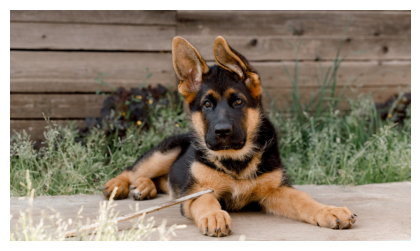

0.97% German shepherd, German shepherd dog, German police dog, alsatian
0.94% Chihuahua
0.79% kelpie
0.73% dingo, warrigal, warragal, Canis dingo
0.67% Border terrier


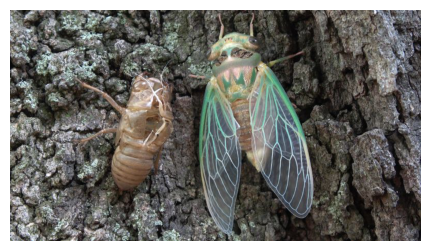

5.70% cicada, cicala
0.86% leafhopper
0.72% hoopskirt, crinoline
0.61% overskirt
0.56% stinkhorn, carrion fungus


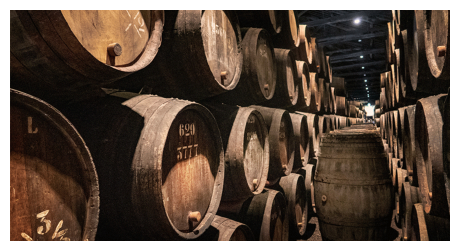

1.30% barrel, cask
0.86% wooden spoon
0.79% cowboy boot
0.68% clog, geta, patten, sabot
0.57% shoe shop, shoe-shop, shoe store


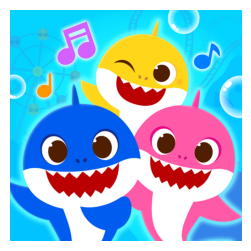

1.50% tray
0.95% rubber eraser, rubber, pencil eraser
0.89% umbrella
0.88% pencil sharpener
0.79% maraca


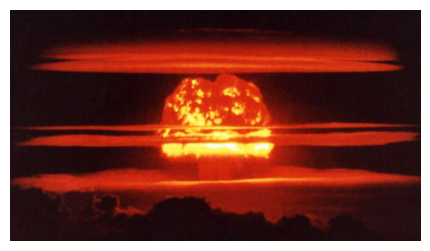

0.98% theater curtain, theatre curtain
0.53% jack-o'-lantern
0.52% triumphal arch
0.50% paddlewheel, paddle wheel
0.48% cinema, movie theater, movie theatre, movie house, picture palace


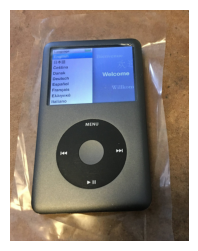

4.00% iPod
1.23% loudspeaker, speaker, speaker unit, loudspeaker system, speaker system
0.89% remote control, remote
0.89% cellular telephone, cellular phone, cellphone, cell, mobile phone
0.85% modem


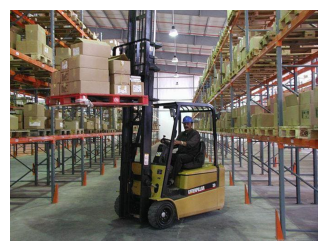

1.28% forklift
0.71% bookshop, bookstore, bookstall
0.70% library
0.51% streetcar, tram, tramcar, trolley, trolley car
0.47% trolleybus, trolley coach, trackless trolley


In [7]:
URLS = [
    "https://d.newsweek.com/en/full/2201052/dog.jpg",
    "https://cdn.britannica.com/30/222430-138-E30A474D/did-you-know-17-year-cicada.jpg?w=800&h=450&c=crop",
    "https://grapeescapes.net/wp-content/uploads/Taylors-Winery-Credits-Svetlana-Gumerova.gif",
    "https://downloadr2.apkmirror.com/wp-content/uploads/2023/03/55/64194c65c28bd.png",
    "https://ychef.files.bbci.co.uk/976x549/p0flnxyg.jpg",
    "https://i.etsystatic.com/19007236/r/il/dd3a32/2133570822/il_fullxfull.2133570822_qkhj.jpg",
    "https://imageio.forbes.com/blogs-images/stevebanker/files/2014/03/670px-forklift.jpg?format=jpg&width=1200",
]
for url in URLS:
    predict_topk(alexnet, imagenet_labels, val_aug, k=5, url=url)